# Exploring LSTM models 

In this notebook we run lstm models on Infodengue data.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import os
#os.chdir("..")

import sys
sys.path.append('../')
from infodenguepredict.models.deeplearning.lstm import *
from infodenguepredict.metrics.metrics import *
import pickle
import getpass, os
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import backend as K
from sklearn.metrics import *
import pandas as pd
from time import time

Using TensorFlow backend.


PSQL_USER not found. Declare it as envvar or define a default value.


## Loading the data

To download the data we follow the instructions in the [README.rst](https://github.com/fccoelho/InfoDenguePredict/blob/master/README.rst) file.

We perform our experiments on data from Rio de Janeiro. Let us first read all our data.

In [2]:
data_cluster = pd.read_csv("./sample_data/3304557_cluster.csv",index_col=0)
data_cluster.head()

,casos_3306206,casos_est_3306206,casos_est_min_3306206,casos_est_max_3306206,p_rt1_3306206,p_inc100k_3306206,temp_min_3306206,temp_max_3306206,umid_min_3306206,pressao_min_3306206,...,casos_3300456,casos_est_3300456,casos_est_min_3300456,casos_est_max_3300456,p_rt1_3300456,p_inc100k_3300456,temp_min_3300456,temp_max_3300456,umid_min_3300456,pressao_min_3300456
2010-01-03,1,1.0,1,1,0.0,2.80725,24.333333,33.000000,42.000000,1009.666667,...,3,3.0,3,3,0.0,0.607114,24.333333,33.000000,42.000000,1009.666667
2010-01-10,0,0.0,0,0,0.0,0.00000,25.428571,34.000000,43.285714,1008.000000,...,6,6.0,6,6,0.0,1.214230,25.428571,34.000000,43.285714,1008.000000
2010-01-17,0,0.0,0,0,0.0,0.00000,24.142857,34.000000,43.857143,1010.285714,...,1,1.0,1,1,0.0,0.202371,24.142857,34.000000,43.857143,1010.285714
2010-01-24,0,0.0,0,0,0.0,0.00000,23.714286,34.285714,39.285714,1009.000000,...,4,4.0,4,4,0.0,0.809486,23.714286,34.285714,39.285714,1009.000000
2010-01-31,0,0.0,0,0,0.0,0.00000,23.857143,33.857143,41.285714,1009.857143,...,9,9.0,9,9,0.0,1.821340,23.857143,33.857143,41.285714,1009.857143


The city of Rio is coded as cluster `3304557`. We can easily filter the dataframe above to get only the data corresponding to this cluster.

In [3]:
cluster_rj = data_cluster[[c for c in data_cluster.columns if "3304557" in c.split("_")]]
print(cluster_rj.shape)
print(cluster_rj.columns)
cluster_rj.head()

(488, 10)
Index(['casos_3304557', 'casos_est_3304557', 'casos_est_min_3304557',
       'casos_est_max_3304557', 'p_rt1_3304557', 'p_inc100k_3304557',
       'temp_min_3304557', 'temp_max_3304557', 'umid_min_3304557',
       'pressao_min_3304557'],
      dtype='object')


,casos_3304557,casos_est_3304557,casos_est_min_3304557,casos_est_max_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,30,30.0,30,30,0.0,0.461621,24.333333,33.000000,42.000000,1009.666667
2010-01-10,46,46.0,46,46,0.0,0.707819,25.428571,34.000000,43.285714,1008.000000
2010-01-17,30,30.0,30,30,0.0,0.461621,24.142857,34.000000,43.857143,1010.285714
2010-01-24,51,51.0,51,51,0.0,0.784756,23.714286,34.285714,39.285714,1009.000000
2010-01-31,58,58.0,58,58,0.0,0.892467,23.857143,33.857143,41.285714,1009.857143


Our goal is to predict the first column, `casos_3304557` from the columns `p_rt1_3304557`, `p_inc100k_3304557`, `temp_min_3304557`, `temp_max_3304557`, `umid_min_3304557`, `pressao_min_3304557`.

In [4]:
usecols = ['casos_3304557', 'p_rt1_3304557', 'p_inc100k_3304557',
       'temp_min_3304557', 'temp_max_3304557', 'umid_min_3304557',
       'pressao_min_3304557']
data = cluster_rj[usecols]
data.head()


,casos_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,30,0.0,0.461621,24.333333,33.000000,42.000000,1009.666667
2010-01-10,46,0.0,0.707819,25.428571,34.000000,43.285714,1008.000000
2010-01-17,30,0.0,0.461621,24.142857,34.000000,43.857143,1010.285714
2010-01-24,51,0.0,0.784756,23.714286,34.285714,39.285714,1009.000000
2010-01-31,58,0.0,0.892467,23.857143,33.857143,41.285714,1009.857143


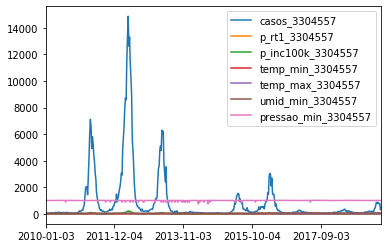

In [5]:
data.plot()

## Normalizing and splitting train/tests sets

In [6]:
### Normalizing data
min_values = np.min(data,axis=0)
max_values = np.max(data,axis=0)
data, _ = normalize_data(data)
#print("data.index: ", data.index)
#timestamps = pd.to_datetime(data.index)
#data.index=timestamps
data.head()

,casos_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,0.002018,0.0,0.002018,0.920721,0.891892,0.488451,0.982712
2010-01-10,0.003094,0.0,0.003094,0.962162,0.918919,0.503404,0.981090
2010-01-17,0.002018,0.0,0.002018,0.913514,0.918919,0.510049,0.983315
2010-01-24,0.003430,0.0,0.003430,0.897297,0.926641,0.456885,0.982063
2010-01-31,0.003901,0.0,0.003901,0.902703,0.915058,0.480144,0.982898


#### Splitting train/test sets

In [7]:
predict_n=2 ## predicting two time steps in the future
Y_column=0
look_back=10 ## using 10 previous time steps as predictors
ratio=0.5 
### Splitting train/test sets
X_train, y_train, X_test, y_test = split_data(data, look_back, ratio, predict_n, Y_column)
#timestamps_train = 

234


We are looking back 10 weeks to get our training data:

In [8]:
print("Training X shape: ", X_train.shape, "\tTraining y shape: ", y_train.shape)
print("Test X shape: ", X_test.shape, "\tTraining y shape: ", y_test.shape)


Training X shape:  (234, 10, 7) 	Training y shape:  (234, 2)
Test X shape:  (243, 10, 7) 	Training y shape:  (243, 2)


## LSTM model
An LSTM model can be retrieved from `lstm.py`.

In [9]:
hidden=4
features=7
predict_n = 2
look_back=10
batch_size=39
model = build_model(hidden, features, predict_n, look_back, batch_size)

W1009 23:48:26.231961 139964815468288 deprecation_wrapper.py:119] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1009 23:48:26.246442 139964815468288 deprecation_wrapper.py:119] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1009 23:48:26.251175 139964815468288 deprecation_wrapper.py:119] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1009 23:48:26.286437 139964815468288 deprecation.py:506] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.

Compilation Time :  0.03400564193725586
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (39, 10, 7)               0         
_________________________________________________________________
lstm_1 (LSTM)                (39, 10, 4)               192       
_________________________________________________________________
dropout_1 (Dropout)          (39, 10, 4)               0         
_________________________________________________________________
lstm_2 (LSTM)                (39, 10, 4)               144       
_________________________________________________________________
dropout_2 (Dropout)          (39, 10, 4)               0         
_________________________________________________________________
lstm_3 (LSTM)                (39, 4)                   144       
_________________________________________________________________
dropout_3 (Dropout)          (39, 4)

### Training model

In [ ]:
hist = train(model, X_train, y_train, batch_size=1, epochs=20, geocode=3304557, overwrite=True)

../infodenguepredict/models/deeplearning/lstm.py:115: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  callbacks=[TB_callback, EarlyStopping(patience=15)]
W1009 23:48:27.351622 139964815468288 deprecation.py:323] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1009 23:48:27.986934 139964815468288 deprecation_wrapper.py:119] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 198 samples, validate on 36 samples


W1009 23:48:28.446377 139964815468288 deprecation_wrapper.py:119] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1009 23:48:28.446865 139964815468288 deprecation_wrapper.py:119] From /home/rio/anaconda3/envs/infodengue/lib/python3.7/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
198/198 [==============================] - 10s 53ms/step - loss: 0.0231 - acc: 0.5087 - mean_absolute_percentage_error: 591.3844 - mean_squared_error: 0.0393 - val_loss: 0.0072 - val_acc: 0.4893 - val_mean_absolute_percentage_error: 1816.2110 - val_mean_squared_error: 0.0080
Epoch 2/20
198/198 [==============================] - 7s 35ms/step - loss: 0.0189 - acc: 0.5066 - mean_absolute_percentage_error: 540.7351 - mean_squared_error: 0.0332 - val_loss: 0.0057 - val_acc: 0.4715 - val_mean_absolute_percentage_error: 1317.7955 - val_mean_squared_error: 0.0066
Epoch 3/20
198/198 [==============================] - 6s 29ms/step - loss: 0.0142 - acc: 0.5205 - mean_absolute_percentage_error: 352.9905 - mean_squared_error: 0.0255 - val_loss: 0.0065 - val_acc: 0.4957 - val_mean_absolute_percentage_error: 1364.1376 - val_mean_squared_error: 0.0076
Epoch 4/20
198/198 [==============================] - 7s 38ms/step - loss: 0.0118 - acc: 0.5483 - mean_absolute_percentage_error: 316.2225 - 

#### Training history

In [ ]:
plot_training_history(hist)

#### Plotting predictions 

In [ ]:
n_shots=10
hidden=4
features=7
predict_n=2
look_back=10
batch_size=477
Xdata = np.concatenate((X_train,X_test))
predicted = predict_with_dropout(model,Xdata,n_shots,hidden,features,predict_n,look_back,\
                         batch_size)
Ydata = np.concatenate((y_train,y_test))
index = data.index


In [ ]:
predicted.shape

# Generating confidence intervals

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import os
#os.chdir("..")

import sys
sys.path.append('../')
from infodenguepredict.models.deeplearning.lstm import *
from infodenguepredict.metrics.metrics import *
import pickle
import getpass, os
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import backend as K
from sklearn.metrics import *
import pandas as pd
from time import time

In [ ]:
%%time
#y_pred_train = model.predict(X_train,batch_size=1)
#y_pred_test = model.predict(X_test,batch_size=1)
#predicted = np.concatenate((y_pred_train,y_pred_test))
#Xdata = np.concatenate((X_train,X_test))
#predicted = predict_with_dropout(model,Xdata,n_predictions,batch_size=1)
#Ydata = np.concatenate((y_train,y_test))
#index = data.index
#index = data.index[:]
index = data.index
label="Rio de Janeiro"
predict_n=2
factor=cluster_rj.loc[:,'casos_3304557'].max()
#split_point = int(len(indice)*0.5)
ratio = 0.5
look_back =10
#plot_n = 2
color_preds = ["red","brown"]
for plot_n, color_pred in enumerate(color_preds):
    #print("plot for t+{}".format(plot_n))
    plot_predicted_vs_data(predicted, Ydata, index, label, ratio, factor,look_back,
                          predict_n,plot_n,color_pred)
    plt.figure()

# Computing metrics on predictions

These metrics are computed on (y_true, y_pred)

In [ ]:
y_pred = np.percentile(predicted, 50, axis=0)
metrics=[]
for t, (y_true, y) in enumerate(zip(Ydata.T,y_pred.T)):
    metrics.append(compute_metrics(y_true,y))
print("Metrics scores at t+1: ")
metrics[0]

In [ ]:
print("Metrics scores at t+2: ")
metrics[1]

# Computing correlations between residues and features

The Pearson-r correlations are computed between the residues y_true-y_pred and each predictor for each time step in the past looked back. 

In [ ]:
predictors_df = data.iloc[:,1:]
look_back=10
predict_n=2
all_correlations = []
for t, (y_true, y) in enumerate(zip(Ydata.T,y_pred.T)):
    all_correlations.append(compute_residue_predictor_correlations(y_true,y, predictors_df, look_back,
                                           predict_n))

In [ ]:
print("Correlations for residues at t+1: ")
all_correlations[0]

In [ ]:
print("Correlations for residues at t+2: ")
all_correlations[1]

######################################################

########################################################

#########################################################

## Nova Iguaçu

Let us now train a model for Nova Iguaçu

In [60]:
os.environ['PSQL_USER']='dengue_ro'
os.environ['PSQL_HOST']='localhost'
os.environ['PSQL_DB']='dengue_ro'
os.environ['PSQL_PASSWORD']=getpass.getpass("Enter the database password: ")

Enter the database password: ········


#### Getting and normalizing  dengue data

In [61]:
geocodes = {"rio": 3304557, "n_iguacu": 3303500}
features = ['casos_', 'p_rt1_', 'p_inc100k_',
       'temp_min_', 'temp_max_', 'umid_min_',
       'pressao_min_']
usecols = [f + str(geocodes["n_iguacu"]) for f in features]
df, _ = get_cluster_data(geocodes["n_iguacu"], clusters=[], data_types=["alerta", "weather"], \
                 cols=None, save=False, doenca='dengue')
data=df.loc[:,usecols]
timestamps=data.index
#data = df[usecols]
### Normalizing data
min_values = np.min(data,axis=0)
max_values = np.max(data,axis=0)
data, _ = normalize_data(data)
data.index=timestamps
print("Shape of data: ", data.shape)
data.head()
#df

Shape of data:  (282, 7)


,casos_3303500,p_rt1_3303500,p_inc100k_3303500,temp_min_3303500,temp_max_3303500,umid_min_3303500,pressao_min_3303500
2012-01-01,0.129338,0.996510,0.129337,0.863720,0.780804,0.715183,0.982919
2012-01-08,0.201893,0.999718,0.201892,0.839779,0.782101,0.645548,0.986736
2012-01-15,0.160883,0.814445,0.160883,0.895028,0.856031,0.535959,0.988271
2012-01-22,0.274448,0.997989,0.274448,0.906077,0.871595,0.537671,0.987434
2012-01-29,0.315457,0.997224,0.315457,0.856354,0.809339,0.611301,0.987154


#### Splitting train/test sets

In [62]:
X_train, y_train, X_test, y_test = split_data(data, look_back=10, ratio=0.75, predict_n=1, Y_column=0)
print("X_train shape: {}\t y_train shape: {}\n".format(X_train.shape,y_train.shape))
print("X_test shape: {}\t y_test shape: {}\n".format(X_test.shape,y_test.shape))

train size:  201
X_train shape: (201, 10, 7)	 y_train shape: (201, 1)

X_test shape: (71, 10, 7)	 y_test shape: (71, 1)



#### Running model

In [63]:
batch_size=67
model = build_model(hidden=4, features=7, predict_n=1, look_back=10, batch_size=batch_size)
hist = train(model, X_train, y_train, batch_size=1, epochs=20, geocode=geocodes["n_iguacu"], overwrite=True)

Compilation Time :  0.024903059005737305
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (67, 10, 7)               0         
_________________________________________________________________
lstm_31 (LSTM)               (67, 10, 4)               192       
_________________________________________________________________
dropout_31 (Dropout)         (67, 10, 4)               0         
_________________________________________________________________
lstm_32 (LSTM)               (67, 10, 4)               144       
_________________________________________________________________
dropout_32 (Dropout)         (67, 10, 4)               0         
_________________________________________________________________
lstm_33 (LSTM)               (67, 4)                   144       
_________________________________________________________________
dropout_33 (Dropout)         (67, 4

/home/rio/geomed/Analysis/lstm.py:173: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  callbacks=[TB_callback, es, cp]


Train on 170 samples, validate on 31 samples
Epoch 1/20
170/170 [==============================] - 8s 46ms/step - loss: 0.0299 - acc: 0.0059 - mean_absolute_percentage_error: 790620.7878 - mean_squared_error: 0.0529 - val_loss: 0.0108 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 268.6704 - val_mean_squared_error: 0.0147
Epoch 2/20
170/170 [==============================] - 5s 32ms/step - loss: 0.0255 - acc: 0.0059 - mean_absolute_percentage_error: 547584.9587 - mean_squared_error: 0.0460 - val_loss: 0.0101 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 159.8642 - val_mean_squared_error: 0.0141
Epoch 3/20
170/170 [==============================] - 6s 37ms/step - loss: 0.0186 - acc: 0.0059 - mean_absolute_percentage_error: 247072.2046 - mean_squared_error: 0.0349 - val_loss: 0.0105 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 168.2371 - val_mean_squared_error: 0.0151
Epoch 4/20
170/170 [==============================] - 4s 24ms/step - loss: 0.01

#### Plotting results 
Note that we reload and recompile the trained model.

Compilation Time :  0.02573227882385254
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (1, 10, 7)                0         
_________________________________________________________________
lstm_40 (LSTM)               (1, 10, 4)                192       
_________________________________________________________________
dropout_40 (Dropout)         (1, 10, 4)                0         
_________________________________________________________________
lstm_41 (LSTM)               (1, 10, 4)                144       
_________________________________________________________________
dropout_41 (Dropout)         (1, 10, 4)                0         
_________________________________________________________________
lstm_42 (LSTM)               (1, 4)                    144       
_________________________________________________________________
dropout_42 (Dropout)         (1, 4) 

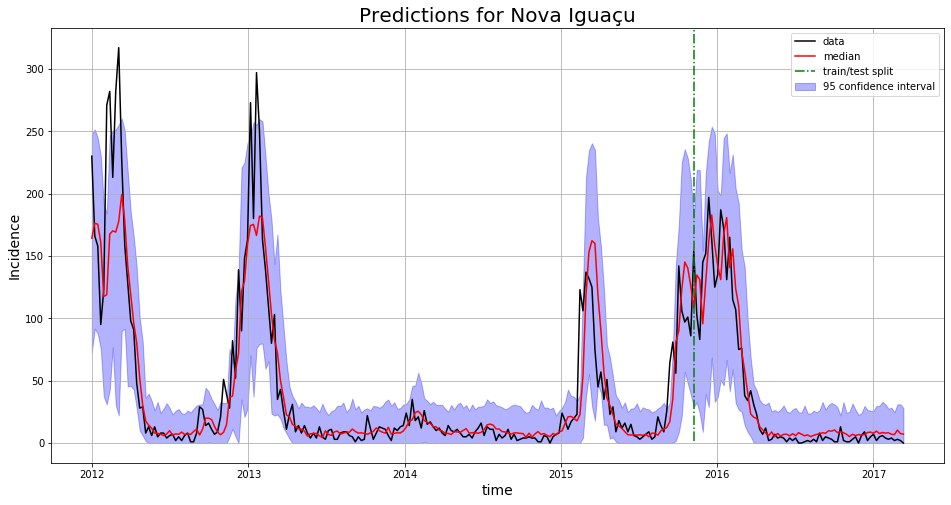

In [68]:
### formatting data and loading model
X, y = np.concatenate((X_train,X_test), axis=0), np.concatenate((y_train,y_test),axis=0)*max_values.iloc[0]

timestamps = data.index[:len(X)]
predictions = make_predictions_batch(X, model, hidden=4, features=7, predict_n = 1, look_back=10,\
                                          batch_size=1,n_pred = 100)*max_values.iloc[0]

### Plotting
plot="median"
confidence=95
data_kw={"label": "data","color":"black"}
pred_kw = {"color":"red"}
fill_kw={"color":"blue","alpha":0.3,"label": "{} confidence interval".format(confidence)}
title_kw={"label": "Predictions for Nova Iguaçu","fontsize":20}
xlabel_kw = {"xlabel": "time","fontsize":14}
ylabel_kw={"ylabel":"Incidence","fontsize":14}
axvline_kw={"x": timestamps[len(X_train)], "linestyle": "dashdot", "ymin":0.05,"ymax":1, "color": "g", "label":"train/test split"}
grid_params={}

fig, ax = plt.subplots(figsize=(16,8))
plot_quantiles(ax,timestamps, predictions[:,:,0],y[:,0],plot,confidence,data_kw,pred_kw,fill_kw,\
               title_kw,xlabel_kw,ylabel_kw,axvline_kw)
### saving figure
fig.savefig("../figures/LSTM_{}_dropout.png".format(geocodes["n_iguacu"]))

In [ ]:
y = np.array([1,2])
x = np.array([[1,2],[]])